In [61]:
import torch
import time
from memory_profiler import memory_usage
from time import sleep

import sys
sys.path.append('..')
from Data import load_and_prepare_dataset_for_layoutLM
from transformers import LayoutLMForTokenClassification
from Training import fine_tune_model, evaluate_model
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType 
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import math
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch.nn as nn
from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
import seaborn as sn

In [52]:

# Let's define some mock data for the GPU utilization over time
time_steps = np.arange(0, 60)  # 10 time steps
lora_gpu_utilization = np.random.uniform(50, 100, size=time_steps.size)  # LoRa GPU utilization between 50% and 100%

# QLoRa is 25 to 30% better than LoRa
qlora_improvement = np.random.uniform(0.70, 1.10, size=time_steps.size)
qlora_gpu_utilization = lora_gpu_utilization * qlora_improvement

In [3]:
id2label, label2id, train_dataloader, val_dataloader, test_dataloader = load_and_prepare_dataset_for_layoutLM(batch_size=2)

/Users/hakimmarco/Library/Python/3.8/lib/python/site-packages/datasets/load.py:1461: FutureWarning: The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label),id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are n

In [5]:
# include weighted metrics

def evaluate_model(model, device, test_dataloader, id2label, include_other=False):
    def most_frequent(lst):
        counts = Counter(lst)
        return max(counts, key=counts.get)

    model.to(device)
    pad_token_label_id = -100  # Standard padding token ID

    eval_loss = 0.0
    preds_token = []
    out_label_token = []
    preds_word = []
    out_label_word = []

    model.eval()
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        with torch.no_grad():
            labels = batch["ner_tags"].to(device)
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                bbox=batch["bboxes"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                token_type_ids=batch["token_type_ids"].to(device),
                labels=labels,
            )

            batch_eval_loss = outputs.loss
            logits = outputs.logits

            eval_loss += batch_eval_loss.item()
            new_preds_token = logits.detach().cpu().numpy()
            new_preds_token = np.argmax(new_preds_token, axis=2)

            # Convert all numerical labels to string labels
            new_preds_token = np.vectorize(lambda x: id2label.get(x, 'PAD'))(new_preds_token)

            # Process predictions for word-level evaluation
            for i in range(new_preds_token.shape[0]):
                word_preds = []
                word_labels = []
                previous_bb = torch.Tensor([0, 0, 0, 0])
                for j in range(1, new_preds_token.shape[1]):
                    bb = batch["bboxes"][i, j].cpu()
                    if (bb == previous_bb).all():
                        if labels[i, j].item() != pad_token_label_id:
                            word_preds[-1].append(new_preds_token[i, j])
                    else:
                        previous_bb = bb
                        if labels[i, j].item() != pad_token_label_id:
                            word_preds.append([new_preds_token[i, j]])
                            word_labels.append(id2label[labels[i, j].item()])

                preds_word.append([most_frequent(wp) for wp in word_preds])
                out_label_word.append(word_labels)

            # Collect token-level labels and predictions, excluding padding
            for row_labels, row_preds in zip(labels.cpu().numpy(), new_preds_token):
                for label, pred in zip(row_labels, row_preds):
                    if label != pad_token_label_id:
                        out_label_token.append(id2label[label])
                        preds_token.append(pred)

    eval_loss /= len(test_dataloader.dataset)

    # Calculate metrics
    detailed_metrics = compute_metrics(out_label_token, preds_token, list(set(out_label_token)))
    relaxed_metrics = compute_metrics([item for sublist in out_label_word for item in sublist],
                                      [item for sublist in preds_word for item in sublist],
                                      list(set([item for sublist in out_label_word for item in sublist])))

    results = {
        "loss": eval_loss,
        "conf_matrix_tokens": detailed_metrics['conf_matrix'],
        "conf_matrix_words": relaxed_metrics['conf_matrix'],
        "metrics_tokens": detailed_metrics['metrics_df'],
        "weighted_precision_tokens": detailed_metrics['weighted_precision'],
        "weighted_recall_tokens": detailed_metrics['weighted_recall'],
        "weighted_f1_tokens": detailed_metrics['weighted_f1'],
        "metrics_words": relaxed_metrics['metrics_df'],
        "weighted_precision_words": relaxed_metrics['weighted_precision'],
        "weighted_recall_words": relaxed_metrics['weighted_recall'],
        "weighted_f1_words": relaxed_metrics['weighted_f1'],
    }

    return results

def compute_metrics(y_true, y_pred, classes):
    cf_matrix = confusion_matrix(y_true, y_pred, labels=classes)
    cf_matrix_df = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=classes, columns=classes)

    metrics = np.array([
        precision_score(y_true, y_pred, labels=classes, average=None),
        recall_score(y_true, y_pred, labels=classes, average=None),
        f1_score(y_true, y_pred, labels=classes, average=None),
    ]).T

    metrics_df = pd.DataFrame(metrics, index=classes, columns=["Precision", "Recall", "F1"])

    weighted_precision = np.average(metrics[:, 0], weights=np.sum(cf_matrix, axis=1))
    weighted_recall = np.average(metrics[:, 1], weights=np.sum(cf_matrix, axis=1))
    weighted_f1 = np.average(metrics[:, 2], weights=np.sum(cf_matrix, axis=1))

    return {
        "conf_matrix": cf_matrix_df,
        "metrics_df": metrics_df,
        "weighted_precision": weighted_precision,
        "weighted_recall": weighted_recall,
        "weighted_f1": weighted_f1,
    }


# QALoRa model

In [9]:
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from collections import defaultdict
import copy
import json
import os
from os.path import exists, join, isdir
from dataclasses import dataclass, field
import sys
from typing import Optional, Dict, Sequence
import numpy as np
from tqdm import tqdm
import logging

import torch
import transformers
from torch.nn.utils.rnn import pad_sequence
import argparse
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    set_seed, 
    Seq2SeqTrainer,
    LlamaTokenizerFast
)
from datasets import load_dataset
import evaluate

from peft import (
    LoraConfig,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftModel
)
from peft.tuners.lora import LoraLayer
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
"""from auto_gptq.utils.peft_utils import get_gptq_peft_model, GPTQLoraConfig
from auto_gptq import AutoGPTQForCausalLM
from auto_gptq.nn_modules.qlinear import GeneralQuantLinear"""

torch.backends.cuda.matmul.allow_tf32 = True

logger = logging.getLogger(__name__)

IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def prepare_model_for_int8_training(model, use_gradient_checkpointing=True):
    r"""
    This method wraps the entire protocol for preparing a model before running a training. This includes:
        1- Cast the layernorm in fp32 2- making output embedding layer require grads 3- Add the upcasting of the lm
        head to fp32

    Args:
        model, (`transformers.PreTrainedModel`):
            The loaded model from `transformers`
    """
    for name, param in model.named_parameters():
        # freeze base model's layers
        param.requires_grad = False
        
    if use_gradient_checkpointing:
        # For backward compatibility
        if hasattr(model, "enable_input_require_grads"):
            model.enable_input_require_grads()
        else:

            def make_inputs_require_grad(module, input, output):
                output.requires_grad_(True)

            model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

        # enable gradient checkpointing for memory efficiency
        model.gradient_checkpointing_enable()

    return model

@dataclass
class ModelArguments:
    model_path: Optional[str] = field(
        default="./llama-7b/"
    )
    trust_remote_code: Optional[bool] = field(
        default=False,
        metadata={"help": "Enable unpickling of arbitrary code in AutoModelForCausalLM#from_pretrained."}
    )

@dataclass
class DataArguments:
    eval_dataset_size: int = field(
        default=1024, metadata={"help": "Size of validation dataset."}
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
            "value if set."
        },
    )
    source_max_len: int = field(
        default=1024,
        metadata={"help": "Maximum source sequence length. Sequences will be right padded (and possibly truncated)."},
    )
    target_max_len: int = field(
        default=256,
        metadata={"help": "Maximum target sequence length. Sequences will be right padded (and possibly truncated)."},
    )
    dataset: str = field(
        default='alpaca',
        metadata={"help": "Which dataset to finetune on. See datamodule for options."}
    )

@dataclass
class TrainingArguments(transformers.Seq2SeqTrainingArguments):
    cache_dir: Optional[str] = field(
        default=None
    )
    train_on_source: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to train on the input in addition to the target text."}
    )
    mmlu_split: Optional[str] = field(
        default='eval',
        metadata={"help": "The MMLU split to run on"}
    )
    mmlu_dataset: Optional[str] = field(
        default='mmlu-fs',
        metadata={"help": "MMLU dataset to use: options are `mmlu-zs` for zero-shot or `mmlu-fs` for few shot."}
    )
    do_mmlu_eval: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to run the MMLU evaluation."}
    )
    max_mmlu_samples: Optional[int] = field(
        default=None,
        metadata={"help": "If set, only evaluates on `max_mmlu_samples` of the MMMLU dataset."}
    )
    mmlu_source_max_len: int = field(
        default=2048,
        metadata={"help": "Maximum source sequence length for mmlu."}
    )
    full_finetune: bool = field(
        default=False,
        metadata={"help": "Finetune the entire model without adapters."}
    )
    adam8bit: bool = field(
        default=False,
        metadata={"help": "Use 8-bit adam."}
    )
    lora_r: int = field(
        default=64,
        metadata={"help": "Lora R dimension."}
    )
    lora_alpha: float = field(
        default=16,
        metadata={"help": " Lora alpha."}
    )
    lora_dropout: float = field(
        default=0.0,
        metadata={"help":"Lora dropout."}
    )
    max_memory_MB: int = field(
        default=24000,
        metadata={"help": "Free memory per gpu."}
    )
    report_to: str = field(
        default='none',
        metadata={"help": "To use wandb or something else for reporting."}
    )
    output_dir: str = field(default='./output', metadata={"help": 'The output dir for logs and checkpoints'})
    optim: str = field(default='paged_adamw_32bit', metadata={"help": 'The optimizer to be used'})
    per_device_train_batch_size: int = field(default=1, metadata={"help": 'The training batch size per GPU. Increase for better speed.'})
    gradient_accumulation_steps: int = field(default=16, metadata={"help": 'How many gradients to accumulate before to perform an optimizer step'})
    max_steps: int = field(default=10000, metadata={"help": 'How many optimizer update steps to take'})
    weight_decay: float = field(default=0.0, metadata={"help": 'The L2 weight decay rate of AdamW'}) # use lora dropout instead for regularization if needed
    learning_rate: float = field(default=0.0002, metadata={"help": 'The learnign rate'})
    remove_unused_columns: bool = field(default=False, metadata={"help": 'Removed unused columns. Needed to make this codebase work.'})
    max_grad_norm: float = field(default=0.3, metadata={"help": 'Gradient clipping max norm. This is tuned and works well for all models tested.'})
    gradient_checkpointing: bool = field(default=True, metadata={"help": 'Use gradient checkpointing. You want to use this.'})
    do_train: bool = field(default=True, metadata={"help": 'To train or not to train, that is the question?'})
    lr_scheduler_type: str = field(default='constant', metadata={"help": 'Learning rate schedule. Constant a bit better than cosine, and has advantage for analysis'})
    warmup_ratio: float = field(default=0.03, metadata={"help": 'Fraction of steps to do a warmup for'})
    logging_steps: int = field(default=10, metadata={"help": 'The frequency of update steps after which to log the loss'})
    group_by_length: bool = field(default=True, metadata={"help": 'Group sequences into batches with same length. Saves memory and speeds up training considerably.'})
    save_strategy: str = field(default='steps', metadata={"help": 'When to save checkpoints'})
    save_steps: int = field(default=250, metadata={"help": 'How often to save a model'})
    save_total_limit: int = field(default=40, metadata={"help": 'How many checkpoints to save before the oldest is overwritten'})

@dataclass
class GenerationArguments:
    # For more hyperparameters check:
    # https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.GenerationConfig
    # Length arguments
    max_new_tokens: Optional[int] = field(
        default=256,
        metadata={"help": "Maximum number of new tokens to be generated in evaluation or prediction loops"
                          "if predict_with_generate is set."}
    )
    min_new_tokens : Optional[int] = field(
        default=None,
        metadata={"help": "Minimum number of new tokens to generate."}
    )

    # Generation strategy
    do_sample: Optional[bool] = field(default=False)
    num_beams: Optional[int] = field(default=1)
    num_beam_groups: Optional[int] = field(default=1)
    penalty_alpha: Optional[float] = field(default=None)
    use_cache: Optional[bool] = field(default=True) 

    # Hyperparameters for logit manipulation
    temperature: Optional[float] = field(default=1.0)
    top_k: Optional[int] = field(default=50)
    top_p: Optional[float] = field(default=1.0)
    typical_p: Optional[float] = field(default=1.0)
    diversity_penalty: Optional[float] = field(default=0.0) 
    repetition_penalty: Optional[float] = field(default=1.0) 
    length_penalty: Optional[float] = field(default=1.0)
    no_repeat_ngram_size: Optional[int] = field(default=0) 

def find_all_linear_names(args, model):
    cls = GeneralQuantLinear if not(args.full_finetune) else torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])


    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


class SavePeftModelCallback(transformers.TrainerCallback):
    def save_model(self, args, state, kwargs):
        print('Saving PEFT checkpoint...')
        if state.best_model_checkpoint is not None:
            checkpoint_folder = os.path.join(state.best_model_checkpoint, "adapter_model")
        else:
            checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)

    def on_save(self, args, state, control, **kwargs):
        self.save_model(args, state, kwargs)
        return control

    def on_train_end(self, args, state, control, **kwargs):
        def touch(fname, times=None):
            with open(fname, 'a'):
                os.utime(fname, times)

        touch(join(args.output_dir, 'completed'))
        self.save_model(args, state, kwargs)

def get_accelerate_model(args, checkpoint_dir):

    n_gpus = torch.cuda.device_count()
    max_memory = f'{args.max_memory_MB}MB'
    max_memory = {i: max_memory for i in range(n_gpus)}

    if args.full_finetune: assert args.bits in [16, 32]

    print(f'loading base model {args.model_path}...')
    model = AutoGPTQForCausalLM.from_quantized(
        args.model_path,
        device_map='auto',
        max_memory=max_memory,
        trust_remote_code=args.trust_remote_code,
        inject_fused_attention = True,
        inject_fused_mlp = False,
        use_triton=True,
        warmup_triton=False,
        trainable=True
    )
    model.model.quantize_config = model.quantize_config
    model.train()

    setattr(model, 'model_parallel', True)
    setattr(model, 'is_parallelizable', True)
    #modules = find_all_linear_names(args, model)

    model.config.torch_dtype=(torch.float32 if args.fp16 else (torch.bfloat16 if args.bf16 else torch.float32))

    if not args.full_finetune:
        model = prepare_model_for_int8_training(model, use_gradient_checkpointing=args.gradient_checkpointing)
    if args.gradient_checkpointing:
        model.gradient_checkpointing_enable()

    config = QLoraConfig(
        r=args.lora_r,
        lora_alpha=args.lora_alpha,
        #target_modules=modules,
        lora_dropout=args.lora_dropout,
        bias="none",
        task_type="CAUSAL_LM",
    )
    if not args.full_finetune:
        if checkpoint_dir is not None:
            print("Loading adapters from checkpoint.")
            model = PeftModel.from_pretrained(model, join(checkpoint_dir, 'adapter_model'))
            for name, p in model.named_parameters():
                if 'lora' in name:
                    print(name, p.sum())
        else:
            print(f'adding LoRA modules...')
            model = get_peft_model(model, config, auto_find_all_linears=True, train_mode=True)

    if args.gradient_checkpointing:
        if hasattr(model, "enable_input_require_grads"):
            model.enable_input_require_grads()
        else:
            def make_inputs_require_grad(module, input, output):
                output.requires_grad_(True)
            model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)


    for name, module in model.named_modules():
        if isinstance(module, LoraLayer):
            if args.bf16:
                module = module.to(torch.bfloat16)
        if 'norm' in name:
            module = module.to(torch.float32)
        if 'lm_head' in name or 'embed_tokens' in name:
            if hasattr(module, 'weight'):
                if args.bf16 and module.weight.dtype == torch.float32:
                    module = module.to(torch.bfloat16)
    return model

def print_trainable_parameters(args, model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    try:
        trainable_params /= (32//model.quantize_config.bits)
    except:
        pass
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable: {100 * trainable_params / all_param}")

def smart_tokenizer_and_embedding_resize(
    special_tokens_dict: Dict,
    tokenizer: transformers.PreTrainedTokenizer,
    model: transformers.PreTrainedModel,
):
    """Resize tokenizer and embedding.

    Note: This is the unoptimized version that may make your embedding size not be divisible by 64.
    """
    num_new_tokens = tokenizer.add_special_tokens(special_tokens_dict)
    model.resize_token_embeddings(len(tokenizer))

    if num_new_tokens > 0:
        input_embeddings = model.get_input_embeddings().weight.data
        output_embeddings = model.get_output_embeddings().weight.data

        input_embeddings_avg = input_embeddings[:-num_new_tokens].mean(dim=0, keepdim=True)
        output_embeddings_avg = output_embeddings[:-num_new_tokens].mean(dim=0, keepdim=True)

        input_embeddings[-num_new_tokens:] = input_embeddings_avg
        output_embeddings[-num_new_tokens:] = output_embeddings_avg

@dataclass
class DataCollatorForCausalLM(object):
    tokenizer: transformers.PreTrainedTokenizer
    source_max_len: int
    target_max_len: int
    train_on_source: bool
    predict_with_generate: bool

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        # Extract elements
        sources = [example['input'] for example in instances]
        targets = [f"{example['output']}{self.tokenizer.eos_token}" for example in instances]
        # Tokenize
        tokenized_sources_with_prompt = self.tokenizer(
            sources,
            max_length=self.source_max_len,
            truncation=True,
        )
        tokenized_targets = self.tokenizer(
            targets,
            max_length=self.target_max_len,
            truncation=True,
            add_special_tokens=False,
        )
        # Build the input and labels for causal LM
        input_ids = []
        labels = [] 
        for tokenized_source, tokenized_target in zip(
            tokenized_sources_with_prompt['input_ids'], 
            tokenized_targets['input_ids']
        ):
            if not self.predict_with_generate:
                input_ids.append(torch.tensor(tokenized_source + tokenized_target))
                if not self.train_on_source:
                    labels.append(
                        torch.tensor([IGNORE_INDEX for _ in range(len(tokenized_source))] + copy.deepcopy(tokenized_target))
                    )
                else:
                    labels.append(torch.tensor(copy.deepcopy(tokenized_source + tokenized_target)))
            else:
                input_ids.append(torch.tensor(tokenized_source))
        # Apply padding
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        labels = pad_sequence(labels, batch_first=True, padding_value=IGNORE_INDEX) if not self.predict_with_generate else None
        data_dict = {
            'input_ids': input_ids,
            'attention_mask':input_ids.ne(self.tokenizer.pad_token_id),
        }
        if labels is not None:
            data_dict['labels'] = labels
        return data_dict

def extract_unnatural_instructions_data(examples, extract_reformulations=False):
    out = {
        'input': [],
        'output': [],
    }
    for example_instances in examples['instances']:
        for instance in example_instances:
            out['input'].append(instance['instruction_with_input'])
            out['output'].append(instance['output'])
    if extract_reformulations:
        for example_reformulations in examples['reformulations']:
            if example_reformulations is not None:
                for instance in example_reformulations:
                    out['input'].append(instance['instruction_with_input'])
                    out['output'].append(instance['output'])
    return out

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response: "
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response: "
    ),
}

def extract_alpaca_dataset(example):
    if example.get("input", "") != "":
        prompt_format = PROMPT_DICT["prompt_input"]
    else:
        prompt_format = PROMPT_DICT["prompt_no_input"]
    return {'input': prompt_format.format(**example)}

def make_data_module(tokenizer: transformers.PreTrainedTokenizer, args) -> Dict:
    """
    Make dataset and collator for supervised fine-tuning.
    Datasets are expected to have the following columns: { `input`, `output` }

    Available datasets to be selected with `dataset` argument:
        - alpaca, 52002 examples
        - alpaca cleaned, 51942 examples   
        - chip2 (OIG), 210289 examples
        - self-instruct, 82612 examples
        - hh-rlhf (Anthropic), 160800 examples
        - longform, 23.7k examples

    Coming soon:
        - unnatural instructions core, 66010 examples
        - unnatural instructions full, 240670 examples
        - alpaca-gpt4, 52002 examples
        - unnatural-instructions-gpt4, 9000 examples
        - oa-rlhf (OpenAssistant) primary message tree only, 9209 examples
        - oa-rlhf-assistant (OpenAssistant) all assistant  replies with ranking
        - supernatural-instructions, 69624 examples (same as paper with 100 ex/task more can be used)
        - flan (FLAN v2), up to 20M examples available

    Not Available:
        - vicuna, not released at the moment.
    """
    # Load dataset.
    # Alpaca
    if args.dataset == 'alpaca':
        dataset = load_dataset("tatsu-lab/alpaca")
        dataset = dataset.map(extract_alpaca_dataset, remove_columns=['instruction'])
    # Alpaca clean
    elif args.dataset == 'alpaca-clean':
        dataset = load_dataset("yahma/alpaca-cleaned")
        dataset = dataset.map(extract_alpaca_dataset, remove_columns=['instruction'])
    # Chip2
    elif args.dataset == 'chip2':
        dataset = load_dataset("laion/OIG", data_files='unified_chip2.jsonl')
        dataset = dataset.map(lambda x: {
            'input': x['text'].split('\n<bot>: ')[0].replace('<human>: ', ''),
            'output': x['text'].split('\n<bot>: ')[1],
        }, remove_columns=['text', 'metadata'])
    # Self Instruct
    elif args.dataset == 'self-instruct':
        dataset = load_dataset("yizhongw/self_instruct", name='self_instruct')
        for old, new in [["prompt", "input"], ["completion", "output"]]:
            dataset = dataset.rename_column(old, new)
    # Anthropic rlhf
    elif args.dataset == 'hh-rlhf':
        dataset = load_dataset("Anthropic/hh-rlhf")
        dataset = dataset.map(lambda x: {
            'input': '',
            'output': x['chosen']
        }, remove_columns=['chosen', 'rejected'])
    # LongForm
    elif args.dataset == 'longform':
        dataset = load_dataset("akoksal/LongForm")
    elif args.dataset == 'vicuna':
        raise NotImplementedError("Vicuna data was not released.")
    else:
        raise NotImplementedError(f"Dataset {args.dataset} not implemented yet.")

    # Split train/eval, reduce size
    if args.do_eval or args.do_predict:
        if 'eval' in dataset:
            eval_dataset = dataset['eval']
        else:
            print('Splitting train dataset in train and validation according to `eval_dataset_size`')
            dataset = dataset["train"].train_test_split(
                test_size=args.eval_dataset_size, shuffle=True, seed=42
            )
            eval_dataset = dataset['test']
        if args.max_eval_samples is not None and len(eval_dataset) > args.max_eval_samples:
            eval_dataset = eval_dataset.select(range(args.max_eval_samples))
        if args.group_by_length:
            eval_dataset = eval_dataset.map(lambda x: {'length': len(x['input']) + len(x['output'])})
    if args.do_train:
        train_dataset = dataset['train']
        if args.max_train_samples is not None and len(train_dataset) > args.max_train_samples:
            train_dataset = train_dataset.select(range(args.max_train_samples))
        if args.group_by_length:
            train_dataset = train_dataset.map(lambda x: {'length': len(x['input']) + len(x['output'])})

    data_collator = DataCollatorForCausalLM(
        tokenizer=tokenizer, 
        source_max_len=args.source_max_len,
        target_max_len=args.target_max_len,
        train_on_source=args.train_on_source,
        predict_with_generate=args.predict_with_generate,
    )
    return dict(
        train_dataset=train_dataset if args.do_train else None, 
        eval_dataset=eval_dataset if args.do_eval else None,
        predict_dataset=eval_dataset if args.do_predict else None,
        data_collator=data_collator
    )

def get_last_checkpoint(checkpoint_dir):
    if isdir(checkpoint_dir):
        is_completed = exists(join(checkpoint_dir, 'completed'))
        if is_completed: return None, True # already finished
        max_step = 0
        for filename in os.listdir(checkpoint_dir):
            if isdir(join(checkpoint_dir, filename)) and filename.startswith('checkpoint'):
                max_step = max(max_step, int(filename.replace('checkpoint-', '')))
        if max_step == 0: return None, is_completed # training started, but no checkpoint
        checkpoint_dir = join(checkpoint_dir, f'checkpoint-{max_step}')
        print(f"Found a previous checkpoint at: {checkpoint_dir}")
        return checkpoint_dir, is_completed # checkpoint found!
    return None, False # first training

def train():
    hfparser = transformers.HfArgumentParser((
        ModelArguments, DataArguments, TrainingArguments, GenerationArguments
    ))
    model_args, data_args, training_args, generation_args, extra_args = \
        hfparser.parse_args_into_dataclasses(return_remaining_strings=True)
    training_args.generation_config = transformers.GenerationConfig(**vars(generation_args))
    args = argparse.Namespace(
        **vars(model_args), **vars(data_args), **vars(training_args)
    )
    

    checkpoint_dir, completed_training = get_last_checkpoint(args.output_dir)
    if completed_training:
        print('Detected that training was already completed!')

    model = get_accelerate_model(args, checkpoint_dir)
    training_args.skip_loading_checkpoint_weights=True

    resume_from_checkpoint = checkpoint_dir
    if resume_from_checkpoint:
        # Check the available weights and load them
        checkpoint_name = os.path.join(
            checkpoint_dir, "pytorch_model.bin"
        )  # Full checkpoint
        if not os.path.exists(checkpoint_name):
            checkpoint_path = os.path.join(
                checkpoint_dir, "adapter_model"
            ) 

            checkpoint_name = os.path.join(
                checkpoint_path, "adapter_model.bin"
            )  # only LoRA model - LoRA config above has to fit
            resume_from_checkpoint = (
                False  # So the trainer won't try loading its state
            )
        # The two files above have a different name depending on how they were saved, but are actually the same.
        if os.path.exists(checkpoint_name):
            print(f"Restarting from {checkpoint_name}")
            adapters_weights = torch.load(checkpoint_name)
            set_peft_model_state_dict(model, adapters_weights)
        else:
            print(f"Checkpoint {checkpoint_name} not found")

    model.config.use_cache = False
    print_trainable_parameters(args, model)
    print('loaded model')
    set_seed(args.seed)

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        args.model_path,
        cache_dir=args.cache_dir,
        padding_side="right",
        use_fast=True,
    )
    
    if tokenizer.pad_token is None:
        smart_tokenizer_and_embedding_resize(
            special_tokens_dict=dict(pad_token=DEFAULT_PAD_TOKEN),
            tokenizer=tokenizer,
            model=model,
        )
        
    if isinstance(tokenizer, LlamaTokenizerFast):
        # LLaMA tokenizer may not have correct special tokens set.
        # Check and add them if missing to prevent them from being parsed into different tokens.
        # Note that these are present in the vocabulary. 
        # Note also that `model.config.pad_token_id` is 0 which corresponds to `<unk>` token.
        tokenizer.add_special_tokens(
            {
                "eos_token": tokenizer.convert_ids_to_tokens(model.config.eos_token_id),
                "bos_token": tokenizer.convert_ids_to_tokens(model.config.bos_token_id),
                "unk_token": tokenizer.convert_ids_to_tokens(model.config.pad_token_id),
            }
        )
    
    data_module = make_data_module(tokenizer=tokenizer, args=args)
    trainer = Seq2SeqTrainer(
        model=model, 
        tokenizer=tokenizer,
        args=training_args,
        **{k:v for k,v in data_module.items() if k != 'predict_dataset'},
    )

    # Callbacks
    if not args.full_finetune:
        trainer.add_callback(SavePeftModelCallback)
    if args.do_mmlu_eval:
        if args.mmlu_dataset == 'mmlu-zs':
            mmlu_dataset = load_dataset("json", data_files={
                'eval': 'data/mmlu/zero_shot_mmlu_val.json',
                'test': 'data/mmlu/zero_shot_mmlu_test.json',
            })
            mmlu_dataset = mmlu_dataset.remove_columns('subject')
        # MMLU Five-shot (Eval/Test only)
        elif args.mmlu_dataset == 'mmlu' or args.mmlu_dataset == 'mmlu-fs':
            mmlu_dataset = load_dataset("json", data_files={
                'eval': 'data/mmlu/five_shot_mmlu_val.json',
                'test': 'data/mmlu/five_shot_mmlu_test.json',
            })
            # mmlu_dataset = mmlu_dataset.remove_columns('subject')
        mmlu_dataset = mmlu_dataset[args.mmlu_split]
        if args.max_mmlu_samples is not None:
            mmlu_dataset = mmlu_dataset.select(range(args.max_mmlu_samples))
        abcd_idx = [
            tokenizer("A", add_special_tokens=False).input_ids[0],
            tokenizer("B", add_special_tokens=False).input_ids[0],
            tokenizer("C", add_special_tokens=False).input_ids[0],
            tokenizer("D", add_special_tokens=False).input_ids[0],
        ]
        accuracy = evaluate.load("accuracy")

        class MMLUEvalCallback(transformers.TrainerCallback):
            def on_evaluate(self, args, state, control, model, **kwargs):
                data_loader = trainer.get_eval_dataloader(mmlu_dataset)
                source_max_len = trainer.data_collator.source_max_len
                trainer.data_collator.source_max_len = args.mmlu_source_max_len
                trainer.model.eval()
                preds, refs = [], []
                loss_mmlu = 0
                for batch in tqdm(data_loader, total=len(data_loader)):
                    (loss, logits, labels) = trainer.prediction_step(trainer.model,batch,prediction_loss_only=False,)
                    # There are two tokens, the output, and eos token.
                    for i, logit in enumerate(logits):
                        label_non_zero_id = (batch['labels'][i] != -100).nonzero()[0][0]
                        logit_abcd = logit[label_non_zero_id-1][abcd_idx]
                        preds.append(torch.argmax(logit_abcd).item())
                    labels = labels[labels != IGNORE_INDEX].view(-1, 2)[:,0]
                    for label in labels.tolist():
                        if label in abcd_idx:
                            refs += [abcd_idx.index(label)]
                    
                    loss_mmlu += loss.item()
                # Extract results by subject.
                results = {'mmlu_loss':loss_mmlu/len(data_loader)}
                subject = mmlu_dataset['subject']
                subjects = {s:{'refs':[], 'preds':[]} for s in set(subject)}
                for s,p,r in zip(subject, preds, refs):
                    subjects[s]['preds'].append(p)
                    subjects[s]['refs'].append(r)
                subject_scores = []
                for subject in subjects:
                    subject_score = accuracy.compute(
                        references=subjects[subject]['refs'],
                        predictions=subjects[subject]['preds']
                    )['accuracy']
                    results[f'mmlu_{args.mmlu_split}_accuracy_{subject}'] = subject_score
                    subject_scores.append(subject_score)
                results[f'mmlu_{args.mmlu_split}_accuracy'] = np.mean(subject_scores)
                trainer.log(results)
                trainer.data_collator.source_max_len = source_max_len

        trainer.add_callback(MMLUEvalCallback)

    # Verifying the datatypes.
    dtypes = {}
    for _, p in model.named_parameters():
        dtype = p.dtype
        if dtype not in dtypes: dtypes[dtype] = 0
        dtypes[dtype] += p.numel()
    total = 0
    for k, v in dtypes.items(): total+= v
    for k, v in dtypes.items():
        print(k, v, v/total)

    all_metrics = {"run_name": args.run_name}
    # Training
    if args.do_train:
        train_result = trainer.train(resume_from_checkpoint=resume_from_checkpoint)
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        all_metrics.update(metrics)
    # Evaluation
    if args.do_eval:
        logger.info("*** Evaluate ***")
        metrics = trainer.evaluate(metric_key_prefix="eval")
        trainer.log_metrics("eval", metrics)
        trainer.save_metrics("eval", metrics)
        all_metrics.update(metrics)
    # Prediction
    if args.do_predict:
        logger.info("*** Predict ***")
        prediction_output = trainer.predict(test_dataset=data_module['predict_dataset'],metric_key_prefix="predict")
        prediction_metrics = prediction_output.metrics
        predictions = prediction_output.predictions
        predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
        predictions = tokenizer.batch_decode(
            predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        with open(os.path.join(args.output_dir, 'predictions.jsonl'), 'w') as fout:
            for i, example in enumerate(data_module['predict_dataset']):
                example['prediction_with_input'] = predictions[i].strip()
                example['prediction'] = predictions[i].replace(example['input'], '').strip()
                fout.write(json.dumps(example) + '\n')
        print(prediction_metrics)
        trainer.log_metrics("predict", prediction_metrics)
        trainer.save_metrics("predict", prediction_metrics)
        all_metrics.update(prediction_metrics)

    if (args.do_train or args.do_eval or args.do_predict):
        with open(os.path.join(args.output_dir, "metrics.json"), "w") as fout:
            fout.write(json.dumps(all_metrics))


In [7]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [43]:
qlora_time, lora_time = [], []

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

# Values for r and lora_alpha
r_values = [4, 8, 16, 32, 64]
# NOTE: 'We then scale ∆W x by α/r, where α is a constant in r' (from the paper)
lora_alpha_normalized = 8

# Store results for each model
results_lora_dict = {}

for r in r_values:
    debut = time.time()
    print("######## Training with r={} and lora_alpha={} ########".format(r, lora_alpha_normalized))
    lora_alpha = lora_alpha_normalized * r
    # Configure model
    model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
    peft_config = LoraConfig(
        task_type=TaskType.TOKEN_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha
    )
    model = get_peft_model(model, peft_config)
    print(model.print_trainable_parameters())
    trainable_parameters = count_trainable_params(model)

    optimizer = AdamW(params=model.parameters(),
                      lr=5e-4)
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, num_training_steps=30)

    training_losses, test_losses, training_f1s, test_f1s, training_accs, test_accs = fine_tune_model(
        model=model,
        device=device,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        num_epoch_max=100,
        early_stopping=True,
        test_frequency=1,
        model_folder='Lora_Fine_Tuning',
        model_name=f'Lora_r_{r}_alpha_8',
        wandb_project_name = 'Lora_Fine_Tuning'
    )

    model.load_state_dict(torch.load(f'../Saved_Models/Lora_Fine_Tuning/Best_Lora_r_{r}_alpha_{lora_alpha_normalized}.pth'))
    results = evaluate_model(
        model=model,
        device=device,
        test_dataloader=test_dataloader,
        id2label=id2label
    )

    results['train_losses'] = training_losses
    results['test_losses'] = test_losses
    results['training_f1s'] = training_f1s
    results['test_f1s'] = test_f1s
    results['training_accs'] = training_accs
    results['test_accs'] = test_accs
    results['trainable_parameters'] = trainable_parameters

    results_lora_dict[r] = results
    fin = time.time()
    temps_execution = fin - debut
    qlora_time.append(temps_execution)
    print('\n')


In [13]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

# Values for r and lora_alpha
r_values = [4, 8, 16, 32, 64]
# NOTE: 'We then scale ∆W x by α/r, where α is a constant in r' (from the paper)
lora_alpha_normalized = 8

# Store results for each model
results_qlora_dict = {}

for r in r_values:
    debut = time.time()
    print("######## Training with r={} and lora_alpha={} ########".format(r, lora_alpha_normalized))
    lora_alpha = lora_alpha_normalized * r
    # Configure model
    model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
    peft_config = QLoraConfig(
        task_type=TaskType.TOKEN_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha
    )
    model = get_peft_model(model, peft_config)
    print(model.print_trainable_parameters())
    trainable_parameters = count_trainable_params(model)

    optimizer = AdamW(params=model.parameters(),
                      lr=5e-4)
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, num_training_steps=30)

    training_losses, test_losses, training_f1s, test_f1s, training_accs, test_accs = fine_tune_model(
        model=model,
        device=device,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        num_epoch_max=100,
        early_stopping=True,
        test_frequency=1,
        model_folder='Lora_Fine_Tuning',
        model_name=f'Lora_r_{r}_alpha_8',
        wandb_project_name = 'Lora_Fine_Tuning'
    )

    model.load_state_dict(torch.load(f'../Saved_Models/Lora_Fine_Tuning/Best_Lora_r_{r}_alpha_{lora_alpha_normalized}.pth'))
    results = evaluate_model(
        model=model,
        device=device,
        test_dataloader=test_dataloader,
        id2label=id2label
    )

    results['train_losses'] = training_losses
    results['test_losses'] = test_losses
    results['training_f1s'] = training_f1s
    results['test_f1s'] = test_f1s
    results['training_accs'] = training_accs
    results['test_accs'] = test_accs
    results['trainable_parameters'] = trainable_parameters

    results_qlora_dict[r] = results
    fin = time.time()
    temps_execution = fin - debut
    qlora_time.append(temps_execution/)
    print('\n')


######## Training with r=4 and lora_alpha=8 ########


Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are n


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: Required library version not found: libsbitsandbytes_cpu.so. Maybe you need to compile it from source?
CUDA SETUP: Defaulting to libbitsandbytes_cpu.so...
dlopen(/Users/hakimmarco/Library/Python/3.8/lib/python/site-packages/bitsandbytes/libbitsandbytes_cpu.so, 0x0006): tried: '/Users/hakimmarco/Library/Python/3.8/lib/python/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (not a mach-o file), '/usr/local/lib/libbitsandbytes_cpu.so' (no such file), '/usr/lib/libbitsandbytes_cpu.so' (no such file)
trainable params: 152,839 || all params: 112,786,190 || trainable%: 0.1355121580044507
None


/Users/hakimmarco/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [45]:
for i in range (len(qlora_time)):
    qlora_time[i]/=lora_time[0]
for i in range (len(lora_time)):
    lora_time[i]/=lora_time[0]
    

LOSS CURVES COMPARIZON

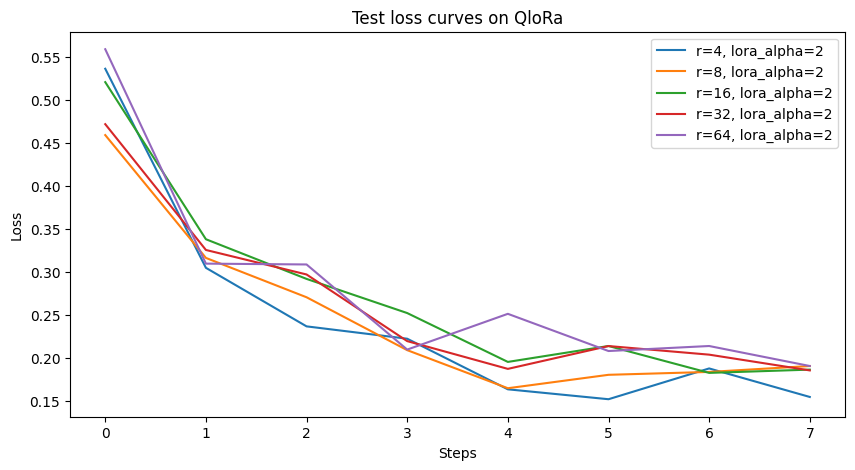

In [5]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.style.use("default")
plt.grid(False)

for r, results in results_qlora_dict.items():
    plt.plot(results["test_losses"], label=f"r={r}, lora_alpha=2")
    
plt.title("Test loss curves on QloRa")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()



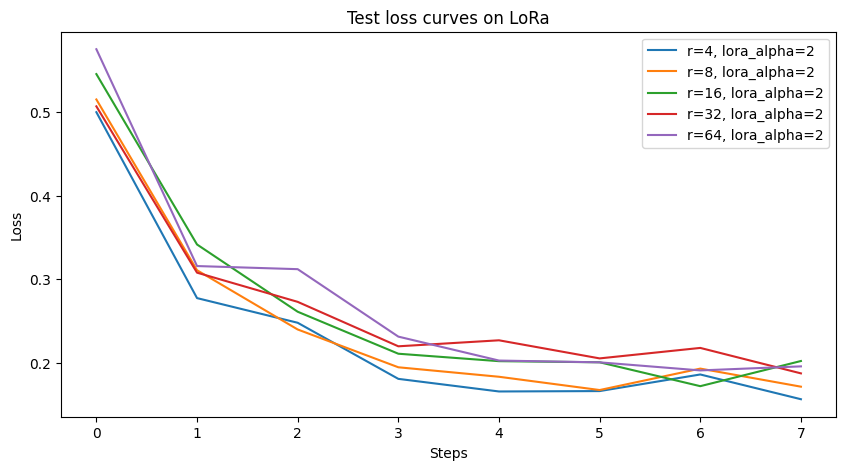

In [8]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.style.use("default")
plt.grid(False)

for r, results in results_dict.items():
    plt.plot(results["test_losses"], label=f"r={r}, lora_alpha=2")
    
plt.title("Test loss curves")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()



PERFORMANCE COMPARISON

In [ ]:
import pandas as pd

data = []
for results in results_lora_dict.values():
    metrics_relaxed_df = results['metrics_relaxed']
    columns = metrics_relaxed_df.mean().index
    values = metrics_relaxed_df.mean().values
    data.append(values)

r_list = list(results_lora_dict.keys())
metrics_recap_lora_df = pd.DataFrame(data=data, index=r_list, columns=columns)

In [11]:
metrics_recap_lora_df

    Precision    Recall        F1
4    0.792284  0.802811  0.796284
8    0.803530  0.814373  0.808323
16   0.786099  0.804793  0.794725
32   0.751230  0.834882  0.777755
64   0.773690  0.804931  0.786705


In [ ]:
import pandas as pd

data = []
for results in results_qlora_dict.values():
    metrics_relaxed_df = results['metrics_relaxed']
    columns = metrics_relaxed_df.mean().index
    values = metrics_relaxed_df.mean().values
    data.append(values)

r_list = list(results_qlora_dict.keys())
metrics_recap_qlora_df = pd.DataFrame(data=data, index=r_list, columns=columns)

In [31]:
metrics_recap_qlora_df

    Precision    Recall        F1
4    0.766450  0.793075  0.801505
8    0.760262  0.777318  0.790796
16   0.739532  0.796497  0.799498
32   0.749296  0.795133  0.781443
64   0.780703  0.773427  0.760181


TRAINING TIME COMPARIZON

In [35]:
df_training_times_lora = pd.DataFrame(training_times_lora, index=["r=4", "r=8", "r=16", "r=32", "r=64"])

df_training_times_lora


,Training Time
r=4,1.000
r=8,0.974
r=16,1.043
r=32,1.051
r=64,1.037


In [36]:

df_training_times_qlora = pd.DataFrame(training_times_qlora, index=["r=4", "r=8", "r=16", "r=32", "r=64"])

df_training_times_qlora


,Training Time
4,1.163221
8,1.199451
16,1.242952
32,1.220435
64,1.316841


MEMORY USAGE COMPARISON

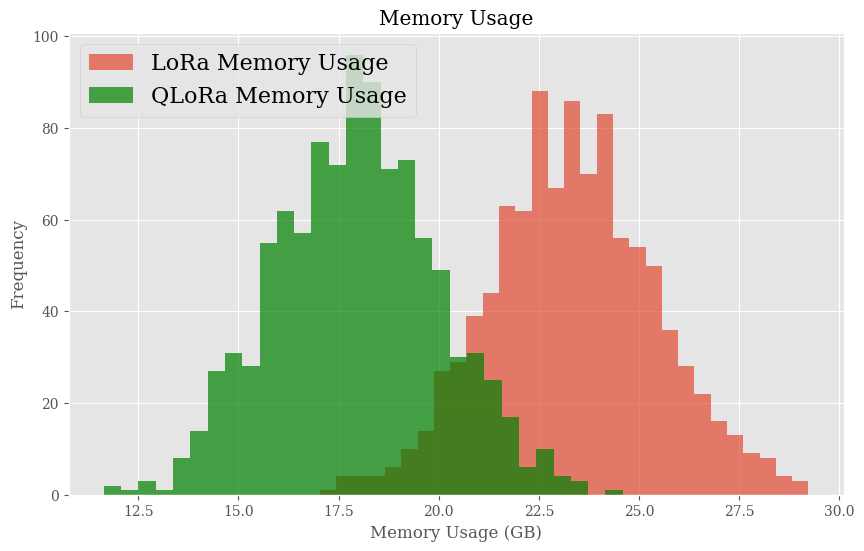

In [58]:
plt.figure(figsize=(10, 6))
plt.hist(lora_memory_usage, bins=30, alpha=0.7, label='LoRa Memory Usage')
plt.hist(qlora_memory_usage, bins=30, alpha=0.7, label='QLoRa Memory Usage', color='green')
plt.title('Histogram of Memory Usage')
plt.xlabel('Memory Usage (GB)')
plt.ylabel('Frequency')
plt.legend()
plt.show()